<a href="https://colab.research.google.com/github/SheriffOladejo/DeepLearning/blob/main/Titanic_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from IPython.display import display

# Install graphviz in Colab
!apt-get install graphviz -qq > /dev/null
!pip install graphviz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.22681614349775783


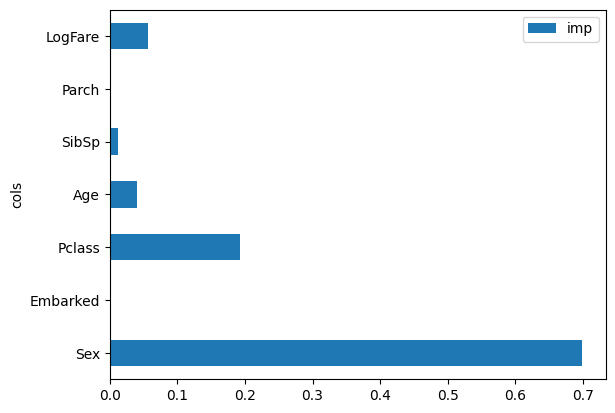

In [12]:
from fastai.imports import *
from google.colab import drive
import os
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


drive.mount('/content/drive')
np.set_printoptions(linewidth=130)

base_path = Path('/content/drive/MyDrive/Titanic Competition')

train_df = pd.read_csv(base_path/'train.csv')
test_df = pd.read_csv(base_path/'test.csv')

modes = train_df.mode().iloc[0]

def process_data(df):
  df['Fare'] = df.Fare.fillna(0)
  df.fillna(modes, inplace=True)
  df['LogFare'] = np.log1p(df['Fare'])
  df['Embarked'] = pd.Categorical(df.Embarked)
  df['Sex'] = pd.Categorical(df.Sex)


def main():
  process_data(train_df)
  process_data(test_df)

  cats = ['Sex', 'Embarked']
  conts = ['Pclass', 'Age', 'SibSp', 'Parch', 'LogFare']
  dep = 'Survived'

  random.seed(42)
  trn_df, val_df = train_test_split(train_df, test_size=0.25)
  trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
  val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

  def xs_y(df):
    xs = df[cats+conts].copy()
    return xs, df[dep] if dep in df else None

  trn_xs, trn_y = xs_y(trn_df)
  val_xs, val_y = xs_y(val_df)

  preds = val_xs.Sex==0
  preds = val_xs.LogFare>2.7

  def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

  def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

  def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

  def _draw_tree(tree, df, size=10, ratio=0.6, precision=2):
      """
      Improved tree visualization function for Colab
      """
      # Export to DOT format
      dot_data = export_graphviz(
          tree,
          out_file=None,
          feature_names=df.columns,
          filled=True,
          rounded=True,
          special_characters=True,
          proportion=False,
          impurity=False,
          precision=precision
      )

      # Create graph from DOT data
      graph = graphviz.Source(dot_data)

      # Set graph attributes
      #graph.graph_attr.update(size=f"{size},{size*ratio}")
      #graph.node_attr.update(fontsize=str(size))

      # Display in notebook
      display(graph)

      # Optionally save to file
      graph.format = 'png'
      graph.render('decision_tree', view=False, cleanup=True)
      return graph

  def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

  def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

  #cols = cats+conts

  # Creating the decision tree
  #cols.remove("Sex")
  #ismale = trn_df.Sex==1
  #males, females = trn_df[ismale], trn_df[~ismale]

  m = DecisionTreeClassifier(min_samples_leaf=50).fit(trn_xs, trn_y)

  trees = [get_tree() for t in range(100)]

  all_probs = [t.predict(val_xs) for t in trees]
  avg_probs = np.stack(all_probs).mean(0)

  print(mean_absolute_error(val_y, avg_probs))

  draw_tree(m, trn_xs, size=10)

  pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

main()